# Image segmentation by a supervised learning 

In [1]:
import os
from pyexpat import model
import torch
from torchvision import transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import statistics

In [2]:
from MyDataset import MyDataset
from MyModel import MyModel
torch.cuda.is_available()

False

## construct dataset for training (split=`mytrain` should be used)

In [3]:
dataset = MyDataset(path='../Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)', split='mytrain')
print('len(dataset)=', len(dataset))
len(set(dataset.raw_label))

  0%|          | 0/250712 [00:00<?, ?it/s]

len(dataset)= 250712


4803

## construct dataloader

In [4]:
batch_size = 256 # you can change this value
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True)

## plot the dataset

In [5]:
iter_data       = iter(dataloader)
(image, mask)   = next(iter_data)
print(image.shape, mask)
print(image.dtype, mask)
print(f'image : (min) = {image.min()}, (max) = {image.max()}')

torch.Size([256, 1, 50, 50]) tensor([3798, 3504, 4154, 3993, 3957, 3703, 1960, 2610, 2602, 1272, 4200, 3520,
        1487, 4475, 2648,  346, 4456, 3685, 3809, 4620, 2812, 1669, 1607, 1510,
        2131, 1509, 3896, 3864,  174,   98,  312, 3778, 4017,  688,  160, 1286,
        2317, 4371, 2214, 3583, 4193,  714, 4194,  567, 4716, 3987, 3736, 1517,
        3244, 1721, 3218, 3374, 4496, 3069, 1235, 2944, 4384, 1906, 3913, 3702,
        4311, 1447, 3477, 2804, 3533, 2443, 1671,  778,  198, 1391, 1529,  380,
        2148, 4113,  793, 4411, 1415, 1894, 3185, 1830, 2334, 1266, 3418, 4570,
        4098, 4551, 3151, 4300, 4260, 3736, 3413, 3262, 4452, 3985, 2990, 2650,
        4799, 2565, 1328, 3130, 4219, 4511,  913, 3795, 2551, 1566,  538, 3525,
        3798, 2819,  545, 3350, 2129, 1119, 1277, 1258, 1073,   71, 4449, 1409,
        3680, 4449, 2899, 4566, 3352, 1449, 4311, 4590,   87,  659, 1920, 4374,
        3380,  727, 1347, 1871, 2448, 2449, 4290, 2517, 2065, 3742, 4405,  157,
        410

## plot images

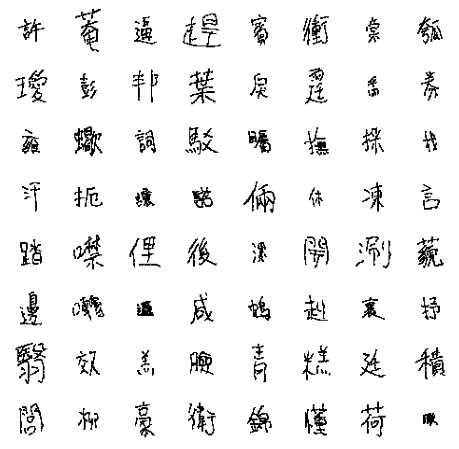

In [6]:
nRow = 8
nCol = 8
plt.figure(figsize=(nRow, nCol))
for i in range(nRow):
    for j in range(nCol):
        idx = nCol * i + j
        plt.subplot(nRow, nCol, idx+1)
        plt.axis('off')
        plt.imshow(image[idx].squeeze(0), cmap='gray')
plt.show()

## construct model

In [7]:
model       = MyModel()
size_model  = model.size()
pred        = model(image)
# print(f'image: {image.shape}')
# print(f'pred: {pred.shape}')
# print('model size =', size_model)
# print(f'image (min)={image.min()}, (max)={image.max()}')
# print(f'pred (min)={pred.min()}, (max)={pred.max()}')

In [8]:
from torchvision import models

def get_resnet_for_50x50(num_classes):
    # 1. ResNet18 불러오기 (Pretrained는 ImageNet(RGB) 기준이라 구조 변경 시 가중치 매칭이 까다로울 수 있어 False 추천)
    model = models.resnet18(weights=None) 
    
    # 2. [수정 포인트] 입력 채널을 3 -> 1로 변경
    # 원래 ResNet의 첫 conv1은 (3, 64, 7x7, stride=2)입니다.
    # 50x50 처럼 작은 이미지는 정보를 너무 많이 잃으므로 (1, 64, 3x3, stride=1)로 바꿉니다.
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    
    # 3. 첫 번째 Pooling 제거 (선택 사항)
    # 50x50 이미지는 너무 작아지면 안 되므로 maxpool을 건너뛰게 할 수도 있습니다.
    # 여기서는 유지하되, 위에서 stride를 1로 줄여서 정보 손실을 막았습니다.
    
    # 4. 마지막 출력층(FC)을 우리 클래스 개수에 맞게 변경
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

## train

In [13]:
criterion  = nn.BCEWithLogitsLoss()

model = get_resnet_for_50x50(len(dataset.classes))

def compute_accuracy(prediction, label):
    pred_label = torch.argmax(prediction, dim=1)
    pred_label = pred_label.to(torch.uint8)
    label      = label.to(torch.uint8)
    bCorrect    = (pred_label == label)
    accuracy    = bCorrect.sum() / len(label)
    return accuracy

model.train()

num_epoch       = 10
loss_epoch      = []
accuracy_epoch  = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # 모델 이동
print(torch.cuda.is_available())

    # ... 학습 진행
for epoch in range(num_epoch):
    loss_batch      = []
    accuracy_batch  = []

    for step, (data, label) in enumerate(tqdm(dataloader)):
        # print(data, label)
        data = data.to(device)
        label = label.to(device)
        pred            = model(data)
        accuracy_value  = compute_accuracy(pred, label)
        loss_value      = torch.Tensor([0.0])

        # optimizing
        # model.optimize(pred, label)

        loss_batch.append(loss_value.item())
        accuracy_batch.append(accuracy_value.item())

    loss_epoch.append(statistics.mean(loss_batch))
    accuracy_epoch.append(statistics.mean(accuracy_batch))

    print(f'Epoch {epoch+1}/{num_epoch}, Loss: {loss_epoch[-1]}, Accuracy: {accuracy_epoch[-1]}')


False


  0%|          | 0/979 [00:00<?, ?it/s]

KeyboardInterrupt: 

## save the trained model

In [ ]:
model.eval()
model.save()    # save the trained model in 'model.pth'

## load the trained model

In [ ]:
model = MyModel(channel_num=8)   # model should not require any argument!
model.load()
model.eval()

MyModel(
  (sequence1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sequence2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (sequence3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (upconv1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (sequence4): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (upconv2): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
  (sequence5): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (sigmoid): Sigmoid()
)

## evaluation

In [ ]:
eval    = MyEval(metric='iou')
result  = MyResult()

## evaluation of the trained model on the training dataset (split=`train`)

In [ ]:
batch_size  = 10 
dataset     = MyDataset(path='data', split='train') 
dataloader  = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=False)
threshold   = 0.5

eval.metric_reset()
for step, (image, mask) in enumerate(tqdm(dataloader)):
    pred = model(image)
    pred = (pred > threshold).float()  # Binarize the prediction
    eval.metric_update(pred, mask)

metric_value = eval.metric_compute()
result.add_result('train', metric_value)
print(f'IoU (train): {metric_value}')

100%|██████████| 40/40 [00:00<00:00, 101.25it/s]

IoU (train): 0.8038308620452881


## plot the segmentation results

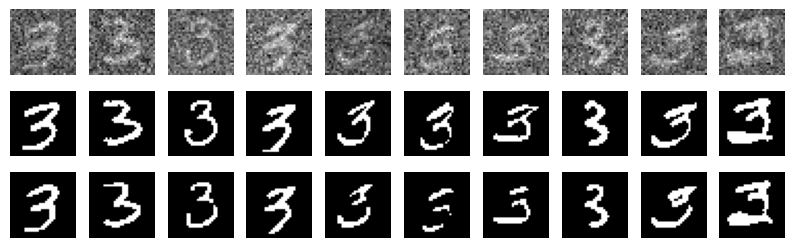

In [ ]:
nRow = 3
nCol = batch_size 
plt.figure(figsize=(nCol, nRow))
for i in range(batch_size):
    plt.subplot(nRow, nCol, nCol * 0 + i + 1)
    plt.imshow(image[i].squeeze(0), cmap='gray')
    plt.axis('off')
    plt.subplot(nRow, nCol, nCol * 1 + i + 1)
    plt.imshow(mask[i].squeeze(0), cmap='gray')
    plt.axis('off')
    plt.subplot(nRow, nCol, nCol * 2 + i +1)
    plt.imshow(pred[i].squeeze(0), cmap='gray')
    plt.axis('off')
plt.show()

## evaluation of the trained model on the validation dataset (split=`val`)

In [ ]:
batch_size  = 10 
dataset     = MyDataset(path='data', split='val') 
dataloader  = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=False)
threshold   = 0.5

eval.metric_reset()
for step, (image, mask) in enumerate(tqdm(dataloader)):
    pred = model(image)
    pred = (pred > threshold).float()  # Binarize the prediction
    eval.metric_update(pred, mask)

metric_value = eval.metric_compute()
result.add_result('val', metric_value)
print(f'IoU (val): {metric_value}')

100%|██████████| 10/10 [00:00<00:00, 99.50it/s]

IoU (val): 0.7569338083267212


## plot the segmentation results

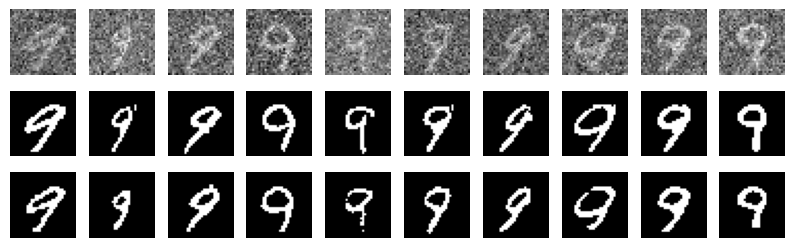

In [ ]:
nRow = 3
nCol = batch_size 
plt.figure(figsize=(nCol, nRow))
for i in range(batch_size):
    plt.subplot(nRow, nCol, nCol * 0 + i + 1)
    plt.imshow(image[i].squeeze(0), cmap='gray')
    plt.axis('off')
    plt.subplot(nRow, nCol, nCol * 1 + i + 1)
    plt.imshow(mask[i].squeeze(0), cmap='gray')
    plt.axis('off')
    plt.subplot(nRow, nCol, nCol * 2 + i +1)
    plt.imshow(pred[i].squeeze(0), cmap='gray')
    plt.axis('off')
plt.show()

## save the result

In [ ]:
result.save()